# Sentiment Analysis on IMDB without pretrained Word Embeddings

In [1]:
import re
import pandas as pd
import numpy as np 
import tensorflow as tf
# import spacy 
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# from spacy.lang.en import English
# nlp = spacy.load("en")

#### Reading data

In [3]:
df = pd.read_csv("/home/kuldeep.singh/clarity_social_media_analysis/imdb_movie_data_project/movie_data.csv")
df.head()

,review,sentiment
0,Usually I love Lesbian movies even when they a...,0.0
1,Prix de Beauté was made on the cusp of the cha...,1.0
2,This lasted several years despite the late hou...,1.0
3,This is 2009 and this way underrated gem has l...,1.0
4,John Waters has given us a genuinely enjoyable...,1.0


#### preprocessing text before doing further operations

In [4]:
def preprocess_text(text):
    text = re.sub("<[^>]*>", "", text)
    strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
    text = re.sub(strip_special_chars, " ", text.lower())
    text = re.sub("  ", " ", text)
    return text

In [5]:
for i in df.review[:10]:
    print i
    print "\n"
    print preprocess_text(i)
    print "\n\n\n"

Usually I love Lesbian movies even when they are not very good. I'm biased, I guess! <br /><br />But this one is just the pits. Yes, the scenery and the buildings are beautiful, and there is a brief but beautiful erotic interlude, but otherwise this movie is just a complete waste of time. Annamarie alternates between sulking and getting high/stoned/passing out on whatever drug or booze is handy, and Ella inexplicably puts up with this abominable behavior through the entire movie. At no time are we given any insight into why this is so, or even why Annamarie is so depressed and withdrawn.<br /><br />If there had at least been some kind of closure in the (potentially romantic? we don't even know!) relationship between the two, there might have been some kind of satisfaction. But although Annamarie at one point asks Ella "why do you love me?" Ella doesn't even acknowledge this. It's never really clear whether this is anything more than an (ill-behaved) Lesbian on a boring road trip with a

#### finding out the distribution of the words in reviews

50000


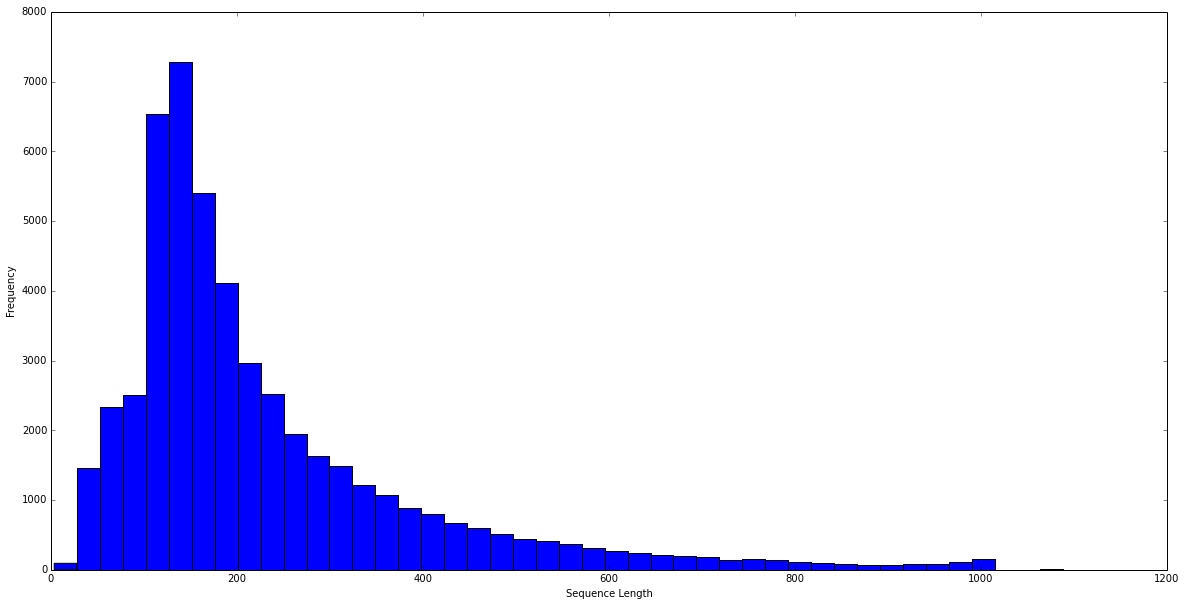

In [6]:
lenList = []
for d in df.review:
    counter = len(d.split())
    lenList.append(counter)
print len(lenList)

#print lenList[:10]
plt.figure(figsize=(20,10))
plt.hist(lenList, 100)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

In [7]:
count = CountVectorizer(max_features=5000)
docs = np.array(df.review)
bag = count.fit_transform(docs)

word2index_map = count.vocabulary_
print len(word2index_map.keys())

index2word_map = {index: word for word, index in word2index_map.iteritems()}

5000


In [8]:
data = [[word2index_map[word] for word in review.lower().split() if word in word2index_map]
        for review in df.review]

50000


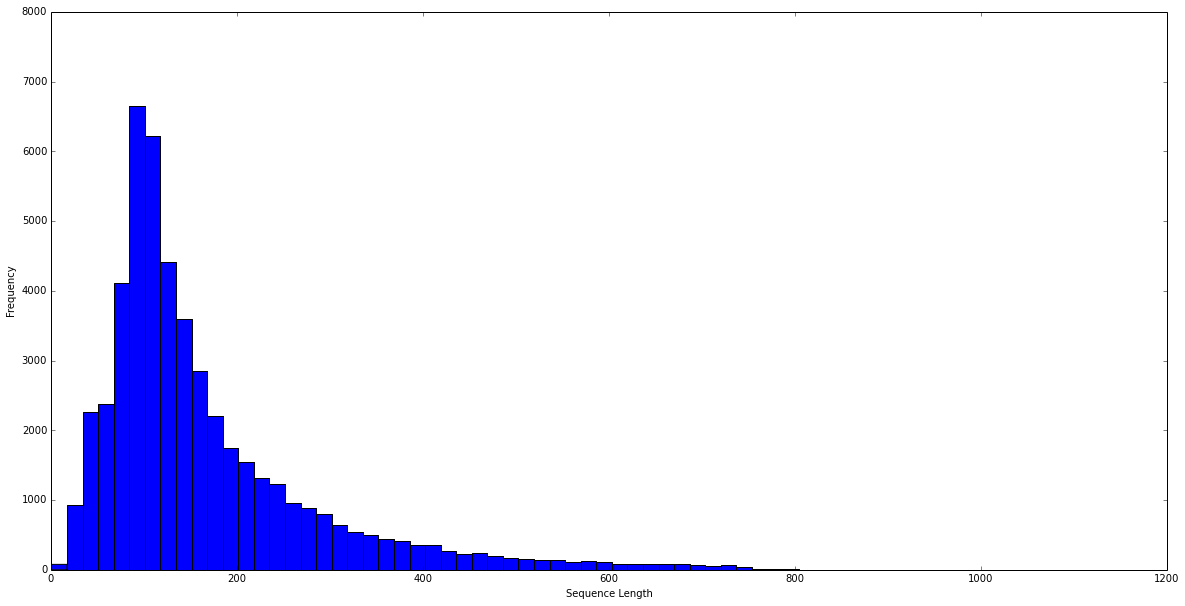

In [9]:
lenList = []
for d in data:
    counter = len(d)
    lenList.append(counter)
print len(lenList)

#print lenList[:10]
plt.figure(figsize=(20,10))
plt.hist(lenList, 100)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

In [10]:
labels = df.sentiment
labels_one_hot = []
for i in range(len(labels)):
    label = int(labels[i])
    one_hot = [0.0]*2
    one_hot[label] = 1.0
    labels_one_hot.append(one_hot)

In [11]:
def generate_batch(batch_size, data_x, data_y):
    instance_indices = list(range(len(data_x)))
    np.random.shuffle(instance_indices)
    batch = instance_indices[:batch_size]
    x = [data_x[i] for i in batch]
    y = [data_y[i] for i in batch]
    return x, y

In [12]:
def variable_summaries(var):
    with tf.name_scope("summaries"):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope("stddev"):
            stddev= tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar("stddev", stddev)

#### adding padding token to dictionaries

In [15]:
len(word2index_map), index2word_map[5000]

(5001, 'PAD')

In [14]:
word2index_map["PAD"] = len(word2index_map)
index2word_map[len(word2index_map) - 1] = "PAD"

### starting the tensorflow code

#### defining constant parameters in the model 

In [16]:
num_lstm_layers = 2
num_classes = 2
batch_size = 64
embedding_dimension = 300
hidden_layer_size = 128
time_steps = 300
vocabulary_size = len(word2index_map)

LOG_DIR = "/home/kuldeep.singh/books/deep learning /tensorflow_tutorials/logs/imdb_tensorflow"

#### padding the sequences

In [17]:
for i in range(len(data)):
    if len(data[i]) < 300:
        data[i].extend([len(word2index_map) - 1]*(300 - len(data[i])))
    else:
        data[i] = data[i][:300]

In [18]:
train_x = data[:20000]
train_y = labels_one_hot[:20000]

test_x = data[20000:30000]
test_y = labels_one_hot[20000:30000]

validation_x = data[30000:40000]
validation_y = labels_one_hot[30000:40000]

In [19]:
# generate_batch(2, train_x, train_y)

In [20]:
_inputs = tf.placeholder(tf.int32, shape=[None, time_steps])
_labels = tf.placeholder(tf.float32, shape=[None, num_classes])

In [21]:
with tf.name_scope("word_embeddings"):
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_dimension], -1.0, 1.0, name="embedding")
    )
    
    embed = tf.nn.embedding_lookup(embeddings, _inputs)

In [26]:
def lstm_cell(hidden_layer_size):
    single_lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0)
    single_lstm_cell = tf.contrib.rnn.DropoutWrapper(single_lstm_cell,  output_keep_prob=_keep_prob)
    return single_lstm_cell

In [27]:
with tf.variable_scope("lstm"):
#     lstm_cell = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size, forget_bias=1.0)
    cell = tf.contrib.rnn.MultiRNNCell(cells=[lstm_cell(hidden_layer_size) for _ in range(num_lstm_layers)],
                                       state_is_tuple=True)
    outputs, states = tf.nn.dynamic_rnn(cell, embed, dtype=tf.float32)
#     outputs, states = tf.nn.dynamic_rnn(lstm_cell, embed, dtype=tf.float32)

weights = {
    "linear_layer": tf.Variable(tf.truncated_normal([hidden_layer_size, num_classes], mean=0, stddev=0.01))
}

biases = {
    "linear_layer": tf.Variable(tf.truncated_normal([num_classes], mean=0, stddev=0.01))
}

In [28]:
final_output = tf.matmul(states[num_lstm_layers-1][1], weights["linear_layer"]) + biases["linear_layer"]

with tf.name_scope("cross_entropy"):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=final_output, labels=_labels))
    tf.summary.scalar("cross_entropy", cross_entropy)

# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=final_output, labels=_labels))

with tf.name_scope("train_step"):
    train_step = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cross_entropy)

with tf.name_scope("accuracy"):
    correct_predictions = tf.equal(tf.argmax(final_output, 1), tf.argmax(_labels, 1))
    accuracy = (tf.reduce_mean(tf.cast(correct_predictions, tf.float32)))*100
    tf.summary.scalar("accuracy", accuracy)
    
merged = tf.summary.merge_all()

In [29]:
with tf.Session() as sess:
    
    train_writer = tf.summary.FileWriter(LOG_DIR + "/train", graph=tf.get_default_graph())
    validation_writer = tf.summary.FileWriter(LOG_DIR + "/test", graph=tf.get_default_graph())
    
    sess.run(tf.global_variables_initializer())
    
    for i in range(10000):
        x_batch, y_batch = generate_batch(batch_size, train_x, train_y)
        
        summary, _ = sess.run([merged, train_step], feed_dict={_inputs: x_batch, _labels: y_batch})
        train_writer.add_summary(summary, i)
        
        if i%100 == 0:
            acc, train_loss =  sess.run([accuracy, cross_entropy], feed_dict=
                                        {_inputs: x_batch, _labels: y_batch})
            
            print "Iteration: " + str(i) +", Minibatch loss: {:.6f}".format(train_loss)\
            + ", Training Accuracy: {:.5f}".format(acc)
        
        if i%10:
            x_val, y_val = generate_batch(batch_size, validation_x, validation_y)
            summary, validation_acc = sess.run([merged, accuracy], 
                                            feed_dict={
                                                _inputs:x_val, _labels:y_val
                                            })
            validation_writer.add_summary(summary, i)
#             if i%100 == 0:
#                 print("validation batch accuracy: %.5f" % (validation_acc))
        
    for test_batch in range(5):
        x_test, y_test = generate_batch(batch_size, test_x,test_y)
        batch_acc, _ = sess.run([accuracy, train_step], feed_dict={
            _inputs:x_test, _labels:y_test
        })
        print("Test batch accuracy %d: %.5f" % (test_batch, batch_acc))
    
#     x_test, y_test = generate_batch(batch_size, test_x,test_y)
#     output_example = sess.run([outputs],feed_dict={_inputs:x_test,
#                                                    _labels:y_test})

#     states_example = sess.run([states[1]],feed_dict={_inputs:x_test, 
#                                                      _labels:y_test})


Iteration: 0, Minibatch loss: 0.693124, Training Accuracy: 50.00000
Iteration: 100, Minibatch loss: 0.693626, Training Accuracy: 50.00000
Iteration: 200, Minibatch loss: 0.692810, Training Accuracy: 54.68750
Iteration: 300, Minibatch loss: 0.690276, Training Accuracy: 56.25000
Iteration: 400, Minibatch loss: 0.672306, Training Accuracy: 57.81250
Iteration: 500, Minibatch loss: 0.679828, Training Accuracy: 51.56250
Iteration: 600, Minibatch loss: 0.689178, Training Accuracy: 53.12500
Iteration: 700, Minibatch loss: 0.667148, Training Accuracy: 53.12500
Iteration: 800, Minibatch loss: 0.695586, Training Accuracy: 39.06250
Iteration: 900, Minibatch loss: 0.660078, Training Accuracy: 54.68750
Iteration: 1000, Minibatch loss: 0.628432, Training Accuracy: 64.06250
Iteration: 1100, Minibatch loss: 0.513566, Training Accuracy: 82.81250
Iteration: 1200, Minibatch loss: 0.450518, Training Accuracy: 87.50000
Iteration: 1300, Minibatch loss: 0.365325, Training Accuracy: 87.50000
Iteration: 1400, M

In [ ]:
# from __future__ import print_function

# from keras.preprocessing import sequence
# from keras.models import Sequential
# from keras.layers import Dense, Embedding
# from keras.layers import LSTM
# from keras.datasets import imdb

# import numpy as np
# np.random.seed(42)
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import roc_auc_score
# from keras.models import Model
# from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
# from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, LSTM, Conv1D, Flatten, multiply, Dropout
# from keras.preprocessing import text, sequence
# from keras.callbacks import Callback, EarlyStopping
# from keras import regularizers
# from keras.optimizers import Adam
# import warnings
# warnings.filterwarnings('ignore')

# max_features = 50000
# maxlen = 200  # cut texts after this number of words (among top max_features most common words)
# batch_size = 128
# embed_size=300

# print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')

# print('Pad sequences (samples x time)')
# x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
# x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# print('x_train shape:', x_train.shape)
# print('x_test shape:', x_test.shape)

# # print('Build model...')
# # model = Sequential()
# # model.add(Embedding(max_features, 128))
# # model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
# # model.add(Dense(1, activation='sigmoid'))
# def get_model():
#     input_ = Input(shape=(maxlen, ))
#     inp = Embedding(max_features, embed_size)(input_)
#     inp = SpatialDropout1D(0.2)(inp)
#     x = inp
#     x = Bidirectional(GRU(128, return_sequences=True))(x)
# #     x = Conv1D(filters=64,kernel_size=2, strides=1,padding='same')(x)
# #     x = SpatialDropout1D(0.2)(x)
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc1 = concatenate([avg_pool, max_pool])
#     outp = Dense(1, activation="sigmoid")(conc1)
# #     outp = Dense(6, activation="sigmoid")(conc1)
# #     outp = Dropout(0.2)(outp)
#     model = Model(inputs=input_, outputs=outp)
#     model.compile(loss='binary_crossentropy',
#                   optimizer=Adam(lr = 0.01),
#                   metrics=['accuracy'])
# #     model.compile(loss='categorical_crossentropy',
# #                   optimizer='adam',
# #                   metrics=['accuracy'])

#     return model

# model = get_model()



# # try using different optimizers and different optimizer configs
# # model.compile(loss='binary_crossentropy',
# #               optimizer='adam',
# #               metrics=['accuracy'])

# print('Train...')
# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=2,
#           validation_data=(x_test, y_test))
# score, acc = model.evaluate(x_test, y_test,
#                             batch_size=batch_size)
# print('Test score:', score)  
# print('Test accuracy:', acc)
